In [1]:
# Importing the basics
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import scipy.stats as stats

%matplotlib inline

In [2]:
ess = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv')

In [5]:
display(ess.head())
display(ess.info())
display(ess.describe())

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8594 entries, 0 to 8593
Data columns (total 13 columns):
cntry      8594 non-null object
idno       8594 non-null float64
year       8594 non-null int64
tvtot      8586 non-null float64
ppltrst    8580 non-null float64
pplfair    8555 non-null float64
pplhlp     8569 non-null float64
happy      8563 non-null float64
sclmeet    8579 non-null float64
sclact     8500 non-null float64
gndr       8584 non-null float64
agea       8355 non-null float64
partner    8577 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 873.0+ KB


None

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
count,8.594000e+03,8594.000000,8586.000000,8580.000000,8555.000000,8569.000000,8563.000000,8579.000000,8500.000000,8584.000000,8355.000000,8577.000000
mean,3.954938e+04,6.500000,3.861985,5.559907,6.005143,5.319874,7.694616,5.192563,2.748941,1.497204,47.470736,1.384867
std,6.267259e+05,0.500029,2.019689,2.233700,2.129866,2.173449,1.735904,1.457643,0.905477,0.500021,18.397369,0.486592
min,1.000000e+00,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,1.000000
25%,1.052000e+03,6.000000,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,1.000000,33.000000,1.000000
50%,1.714000e+03,6.500000,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,1.000000,47.000000,1.000000
75%,2.745000e+03,7.000000,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,2.000000,62.000000,2.000000
max,1.100143e+07,7.000000,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,2.000000,114.000000,2.000000


In [16]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers


def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [25]:
impute_list = ess.columns.to_list()
print(ess.isnull().sum())
drop_list = ['cntry','idno','year']
for i in drop_list:
    impute_list.remove(i)
print(impute_list)

cntry        0
idno         0
year         0
tvtot        8
ppltrst     14
pplfair     39
pplhlp      25
happy       31
sclmeet     15
sclact      94
gndr        10
agea       239
partner     17
dtype: int64
['tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet', 'sclact', 'gndr', 'agea', 'partner']


In [27]:
for col in impute_list:
    ess[col] = knn_impute(target=ess[col], attributes=ess.drop([col],axis=1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=.8)

KeyboardInterrupt: 

In [28]:
ess1 = ess.interpolate()

### Did people become less trusting from 2012 to 2014? Compute results for each country in the sample.

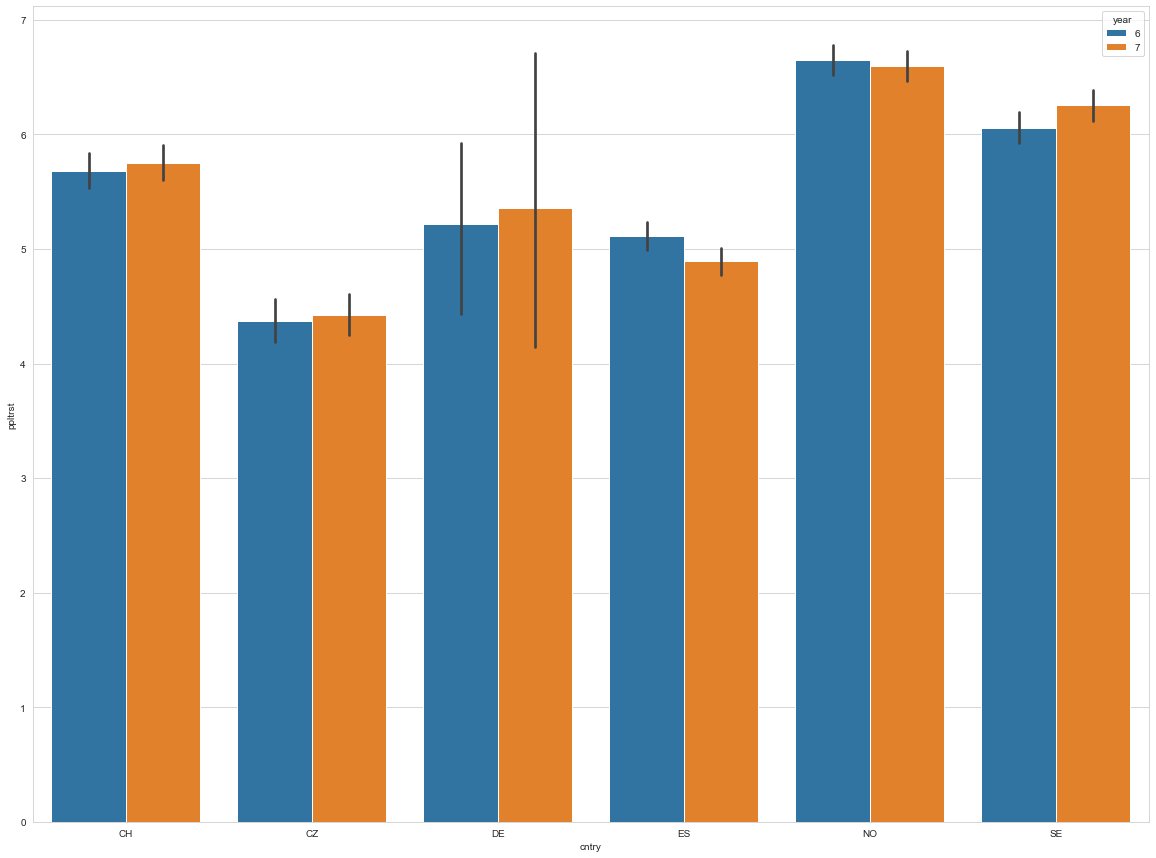

In [33]:
plt.figure(figsize=(20, 15))
sns.barplot(x='cntry',
            y='ppltrst', 
            hue='year', data=ess
            )

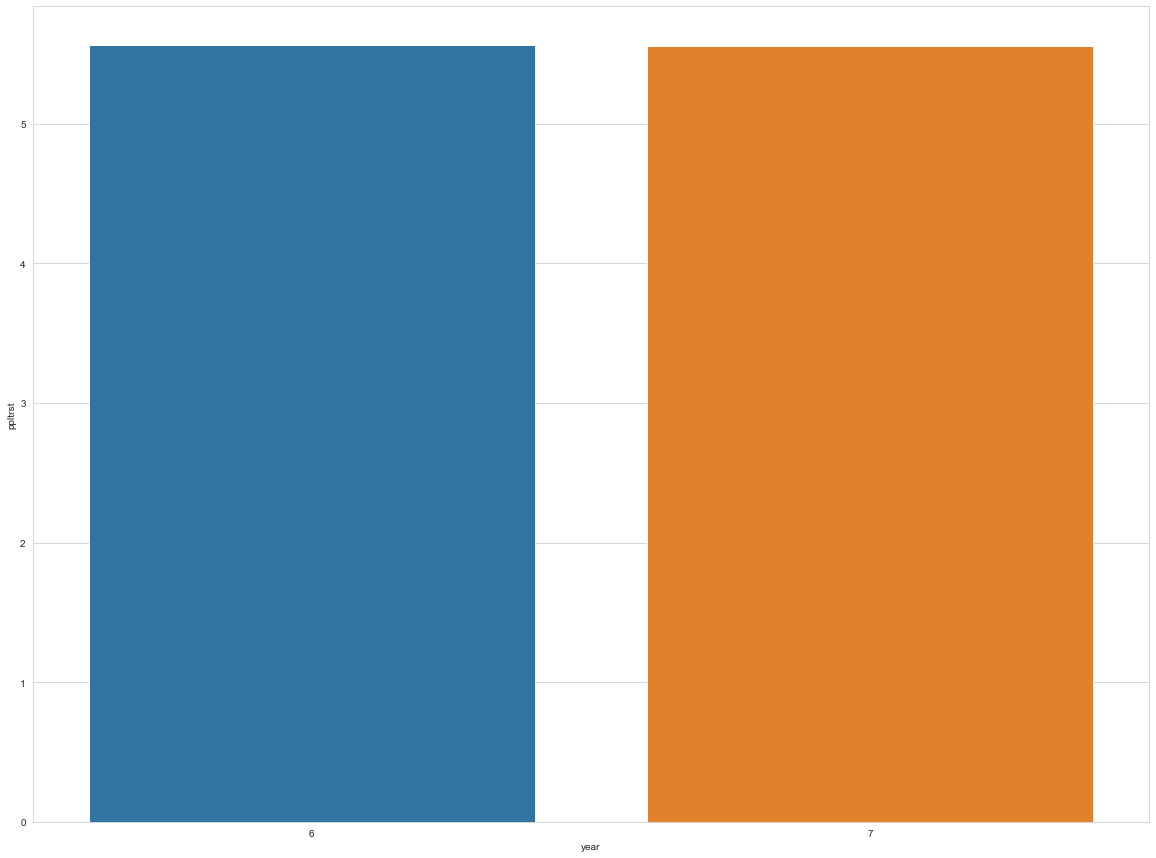

In [37]:
plt.figure(figsize=(20, 15))
sns.barplot(x=ess1.groupby('year')['ppltrst'].mean().index,
            y=ess1.groupby('year')['ppltrst'].mean() 
            )

In [43]:
year_6 = ess.loc[ess['year'] == 6]
year_7 = ess.loc[ess['year'] == 7]
print(stats.ttest_ind(year_6['ppltrst'], year_7['ppltrst']))

Ttest_indResult(statistic=0.13288946947747426, pvalue=0.8942839071641036)


In [50]:
countries = ess1['cntry'].unique().tolist()
#print(countries)
for c in countries:
    test1 = year_6.loc[year_6['cntry'] == c]
    test2 = year_7.loc[year_7['cntry'] == c]
    print('{}:\n'.format(c), stats.ttest_ind(test1['ppltrst'], test2['ppltrst']))
    print('='*60,'\n')

CH:
 Ttest_indResult(statistic=-0.6782716584661505, pvalue=0.49770110247151234)

CZ:
 Ttest_indResult(statistic=-0.41605744697485203, pvalue=0.6774359089282252)

DE:
 Ttest_indResult(statistic=-0.18084358577434545, pvalue=0.8578926631223287)

ES:
 Ttest_indResult(statistic=2.4896394562553126, pvalue=0.012853831381396175)

NO:
 Ttest_indResult(statistic=0.5290377876548692, pvalue=0.5968596561443472)

SE:
 Ttest_indResult(statistic=-2.075329836075086, pvalue=0.0380966088815332)



### Overall there was no statistically significant difference in trust overall, but ES and SE are statistically different from 2012 -> 2014

### Did people become happier from 2012 to 2014? Compute results for each country in the sample.

In [51]:
ess.columns

Index(['cntry', 'idno', 'year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp',
       'happy', 'sclmeet', 'sclact', 'gndr', 'agea', 'partner'],
      dtype='object')

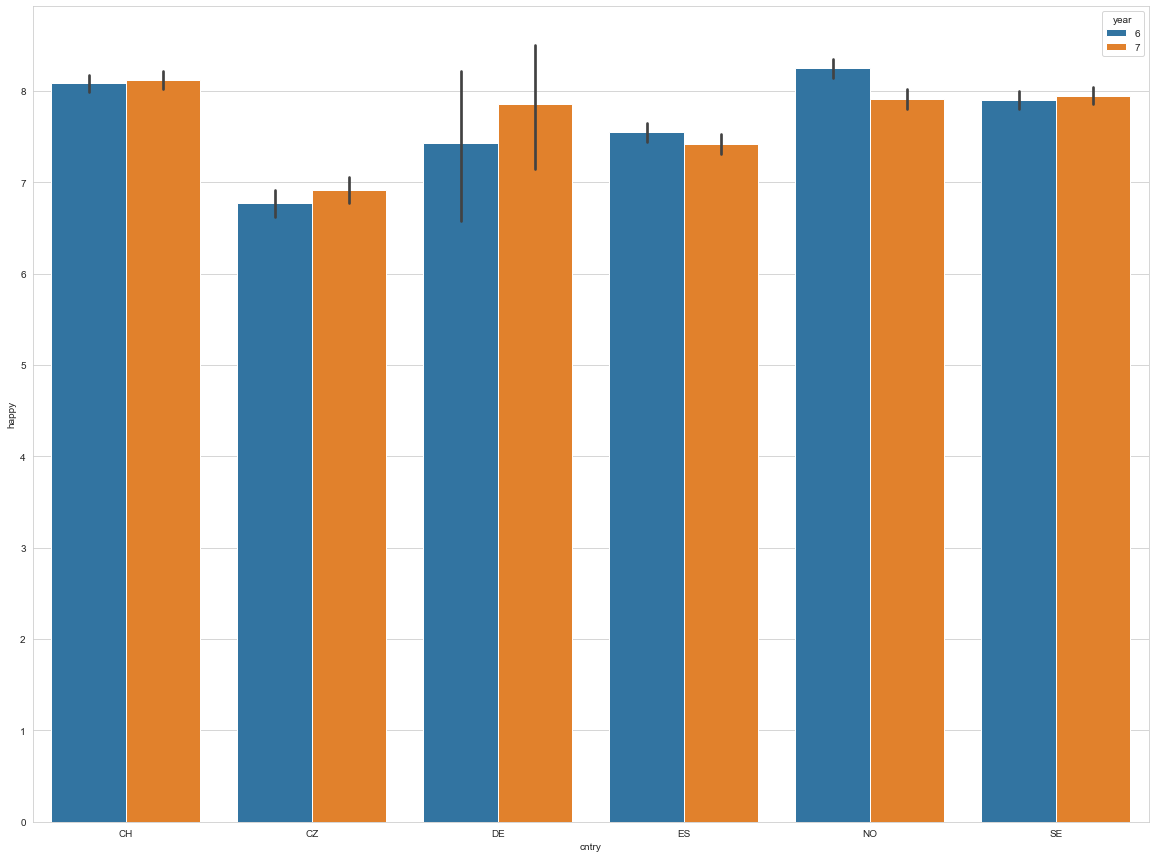

In [52]:
plt.figure(figsize=(20, 15))
sns.barplot(x='cntry',
            y='happy', 
            hue='year', data=ess
            )

In [53]:
print(stats.ttest_ind(year_6['happy'], year_7['happy']))

Ttest_indResult(statistic=1.4771844377451413, pvalue=0.13966285544585413)


In [54]:
for c in countries:
    test1 = year_6.loc[year_6['cntry'] == c]
    test2 = year_7.loc[year_7['cntry'] == c]
    print('{}:\n'.format(c), stats.ttest_ind(test1['happy'], test2['happy']))
    print('='*60,'\n')

CH:
 Ttest_indResult(statistic=-0.4205766877432743, pvalue=0.6741227473803613)

CZ:
 Ttest_indResult(statistic=-1.3714139094555355, pvalue=0.17048010361796584)

DE:
 Ttest_indResult(statistic=-0.7648529270389165, pvalue=0.451246041120838)

ES:
 Ttest_indResult(statistic=1.7002383670653067, pvalue=0.08921437824196307)

NO:
 Ttest_indResult(statistic=4.2414226843846805, pvalue=2.3607073444585215e-05)

SE:
 Ttest_indResult(statistic=-0.6007381148196029, pvalue=0.5480894771713212)



### So it looks as if happiness has statistically changed in all countries but NO

### Who reported watching more TV in 2012, men or women?

In [60]:
year_6.groupby('gndr')['tvtot'].mean()

gndr
1.0    3.901811
2.0    3.944937
Name: tvtot, dtype: float64

In [62]:
test1 = year_6.loc[year_6['gndr'] == 1]
test2 = year_6.loc[year_6['gndr'] == 2]
print(stats.ttest_ind(test1['tvtot'], test2['tvtot']))
print('='*60,'\n')

Ttest_indResult(statistic=-0.7013498566305109, pvalue=0.4831227044193581)



### Women watched more tv both imperically and statistically in 2012

### Who was more likely to believe people were fair in 2012, people living with a partner or people living alone?

In [63]:
ess.columns

Index(['cntry', 'idno', 'year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp',
       'happy', 'sclmeet', 'sclact', 'gndr', 'agea', 'partner'],
      dtype='object')

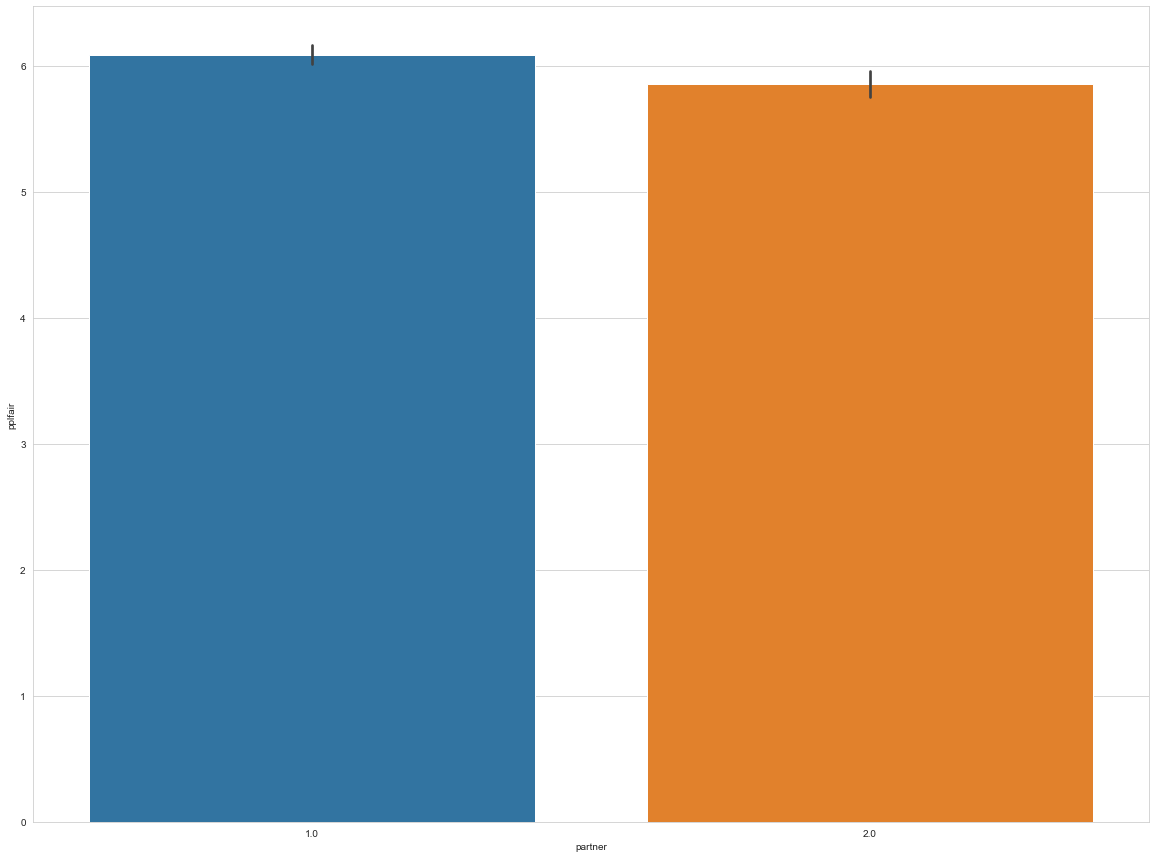

In [68]:
plt.figure(figsize=(20, 15))
sns.barplot(x='partner',
            y='pplfair', 
            data=year_6
            )

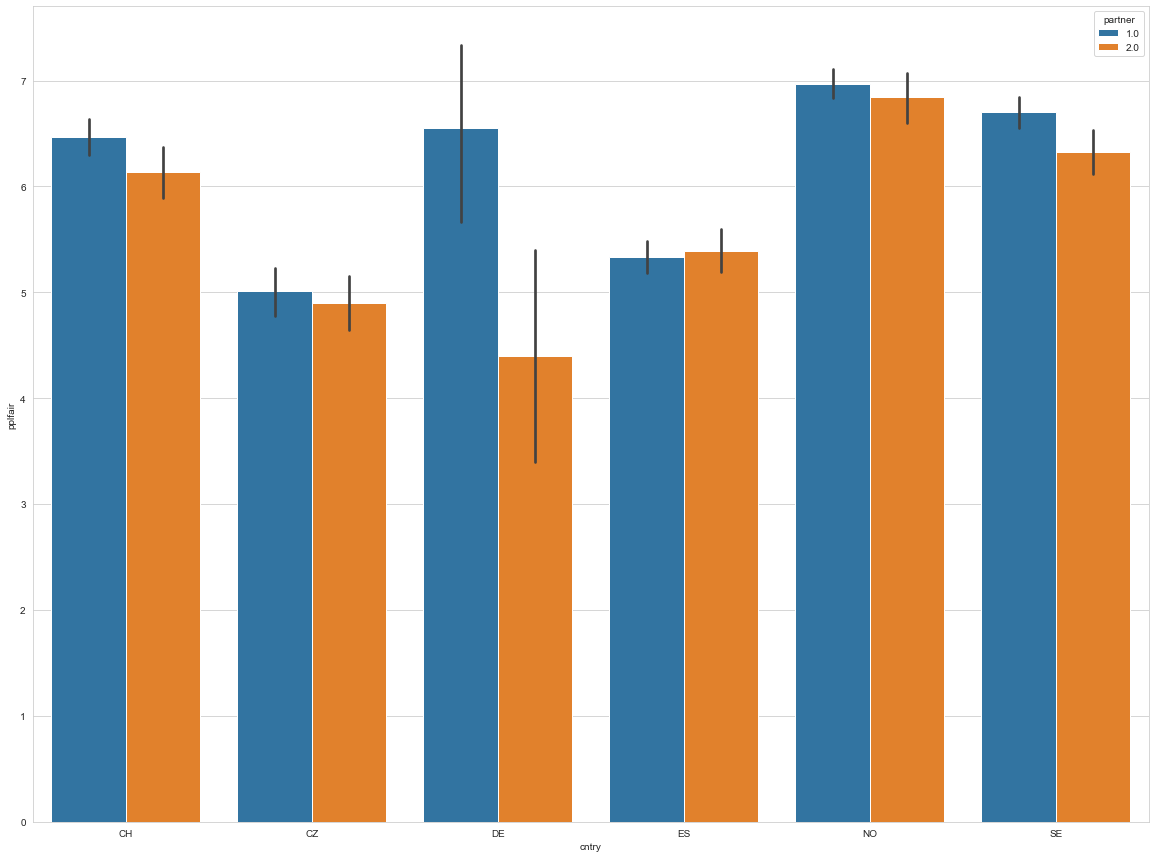

In [64]:
plt.figure(figsize=(20, 15))
sns.barplot(x='cntry',
            y='pplfair', 
            hue='partner', 
            data=year_6
            )

In [66]:
test1 = year_6.loc[year_6['partner'] == 1]
test2 = year_6.loc[year_6['partner'] == 2]
print(stats.ttest_ind(test1['pplfair'], test2['pplfair']))
print('='*60,'\n')

Ttest_indResult(statistic=3.3558320618511264, pvalue=0.000798147680355823)



In [65]:
for c in countries:
    test1 = year_6.loc[year_6['cntry'] == c]
    test2 = year_7.loc[year_7['cntry'] == c]
    test3 = test1.loc[test1['partner'] == 1]
    test4 = test2.loc[test2['partner'] == 2]
    print('{}:\n'.format(c), stats.ttest_ind(test3['pplfair'], test4['pplfair']))
    print('='*60,'\n')

CH:
 Ttest_indResult(statistic=2.0784080083960603, pvalue=0.037993251617462365)

CZ:
 Ttest_indResult(statistic=-0.8636761552612554, pvalue=0.38808736302967295)

DE:
 Ttest_indResult(statistic=-1.7245587981530306, pvalue=0.1186940507459521)

ES:
 Ttest_indResult(statistic=-0.20747706448688844, pvalue=0.8356713977919851)

NO:
 Ttest_indResult(statistic=2.732784256368315, pvalue=0.006426437525981506)

SE:
 Ttest_indResult(statistic=0.14868565399486355, pvalue=0.8818348053003298)



### People who are in a relationship have statistically more trust in people than single people. That changes by country, but overall it holds true

### Pick three or four of the countries in the sample and compare how often people met socially in 2014. Are there differences, and if so, which countries stand out?

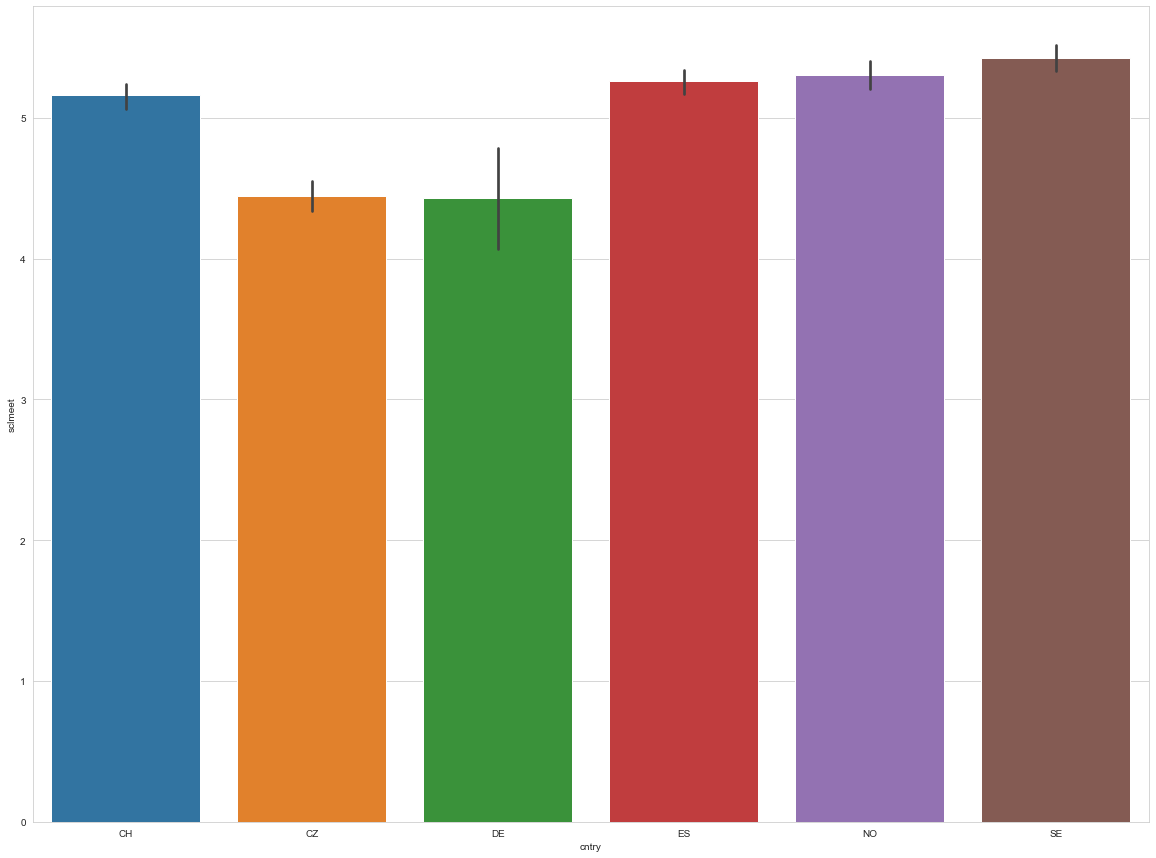

In [76]:
plt.figure(figsize=(20, 15))
sns.barplot(x='cntry',
            y='sclmeet', 
            data=year_7
            )

In [74]:
CH = year_7.loc[year_7['cntry'] == 'CH']
CZ = year_7.loc[year_7['cntry'] == 'CZ']
DE = year_7.loc[year_7['cntry'] == 'DE']
    
F, p = stats.f_oneway(
    CH['sclmeet'],
    CZ['sclmeet'],
    DE['sclmeet'])
print(F)
print(p)

47.917283841438
7.114060759625955e-21


In [75]:
one_way = [CH,CZ,DE]   
print(stats.ttest_ind(CH['sclmeet'], CZ['sclmeet']))
print(stats.ttest_ind(CH['sclmeet'], DE['sclmeet']))
print(stats.ttest_ind(CZ['sclmeet'], DE['sclmeet']))

Ttest_indResult(statistic=9.698514441604395, pvalue=1.3915158420744576e-21)
Ttest_indResult(statistic=2.084704184652674, pvalue=0.03741882154891594)
Ttest_indResult(statistic=0.04216909685153096, pvalue=0.9663764610777132)


### There is a significant difference, but it is really CH that is different. Statistically CZ and DE are very similar

### Pick three or four of the countries in the sample and compare how often people took part in social activities, relative to others their age, in 2014. Are there differences, and if so, which countries stand out?

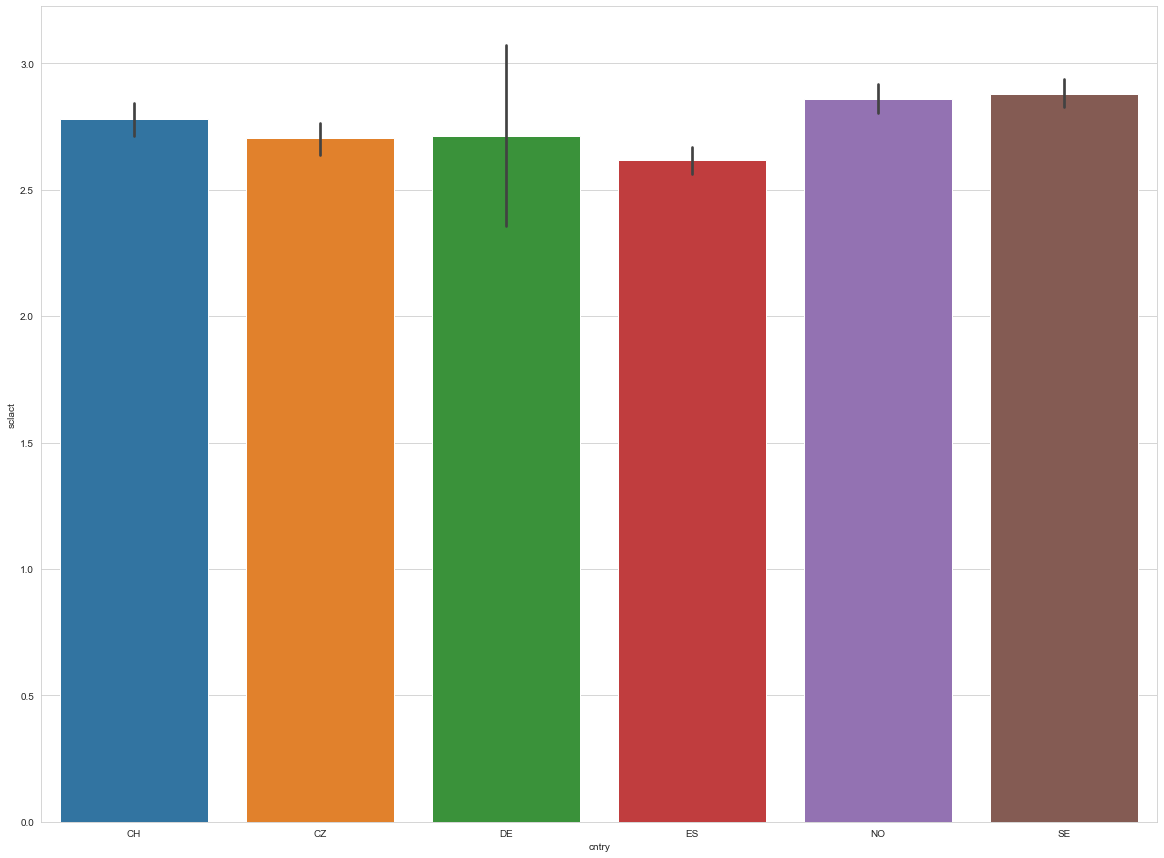

In [78]:
plt.figure(figsize=(20, 15))
sns.barplot(x='cntry',
            y='sclact', 
            data=year_7
            )

In [79]:
F, p = stats.f_oneway(
    CH['sclact'],
    CZ['sclact'],
    DE['sclact'])
print(F)
print(p)

1.300616061553338
0.2726832603128434


In [77]:
print(stats.ttest_ind(CH['sclact'], CZ['sclact']))
print(stats.ttest_ind(CH['sclact'], DE['sclact']))
print(stats.ttest_ind(CZ['sclact'], DE['sclact']))

Ttest_indResult(statistic=1.6052850664037255, pvalue=0.10865203567739788)
Ttest_indResult(statistic=0.26640026959432256, pvalue=0.7900009157539174)
Ttest_indResult(statistic=-0.04331900810165885, pvalue=0.9654601456915707)
